In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.nn.functional import cross_entropy, one_hot

class RepViTBlock(nn.Module):
    def __init__(self, in_channels, se_ratio=0.25, stride=1):
        super().__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.fused = False

        # depthwise 3x3
        self.rbr_dense = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels)
        )

        # depthwise 1x1
        self.rbr_1x1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride, 0, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels)
        )

        # pointwise conv
        self.pwconv = nn.Conv2d(in_channels, in_channels, 1, bias=False)
        self.bn_pw = nn.BatchNorm2d(in_channels)

        # SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, max(1, int(in_channels * se_ratio)), 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(1, int(in_channels * se_ratio)), in_channels, 1),
            nn.Sigmoid()
        )

        self.shortcut = (stride == 1)

    def forward(self, x):
        # Check if we're using reparameterized version
        if hasattr(self, 'rbr_reparam'):
            if self.rbr_reparam.weight.device != x.device:
                self.rbr_reparam = self.rbr_reparam.to(x.device)
            if self.rbr_reparam.weight.dtype != x.dtype:
                self.rbr_reparam = self.rbr_reparam.to(x.dtype)
            y = self.rbr_reparam(x)
        else:
            if not self.fused:
                if self.rbr_dense[0].weight.device != x.device:
                    self.rbr_dense = self.rbr_dense.to(x.device)
                if self.rbr_1x1[0].weight.device != x.device:
                    self.rbr_1x1 = self.rbr_1x1.to(x.device)
            y = self.rbr_dense(x) + self.rbr_1x1(x)

        if self.pwconv.weight.device != x.device:
            self.pwconv = self.pwconv.to(x.device)
            self.bn_pw = self.bn_pw.to(x.device)
        if self.se[1].weight.device != x.device:
            self.se = self.se.to(x.device)

        y = self.pwconv(y)
        y = self.bn_pw(y)
        y = y * self.se(y)
        y = F.relu(y)
        return x + y if self.shortcut else y

    def _fuse_reparam(self):
        device = self.rbr_dense[0].weight.device
        k3, b3 = self._fuse_conv_bn(self.rbr_dense)
        k1, b1 = self._fuse_conv_bn(self.rbr_1x1)
        k1_pad = F.pad(k1, [1, 1, 1, 1])
        fused_k = k3 + k1_pad
        fused_b = b3 + b1

        self.rbr_reparam = nn.Conv2d(
            self.in_channels, self.in_channels, kernel_size=3,
            stride=self.stride, padding=1, groups=self.in_channels, bias=True
        ).to(device)

        with torch.no_grad():
            self.rbr_reparam.weight.copy_(fused_k)
            self.rbr_reparam.bias.copy_(fused_b)

        if hasattr(self, 'rbr_dense'):
            del self.rbr_dense
        if hasattr(self, 'rbr_1x1'):
            del self.rbr_1x1
        self.fused = True

    @staticmethod
    def _fuse_conv_bn(branch):
        conv = branch[0]
        bn = branch[1]
        w = conv.weight
        if conv.bias is None:
            bias = torch.zeros(w.size(0), device=w.device)
        else:
            bias = conv.bias

        bn_var_rsqrt = 1.0 / torch.sqrt(bn.running_var + bn.eps)
        w_fused = w * (bn.weight * bn_var_rsqrt).reshape(-1, 1, 1, 1)
        b_fused = bn.bias + (bias - bn.running_mean) * bn_var_rsqrt * bn.weight
        return w_fused, b_fused

    def fuse(self):
        if not self.fused:
            self._fuse_reparam()
        return self

class RepViTBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            RepViTBlock(32)
        )
        self.stage2 = nn.Sequential(
            RepViTBlock(32, stride=2),
            RepViTBlock(32)
        )
        self.stage3 = nn.Sequential(
            RepViTBlock(32, stride=2),
            RepViTBlock(32),
            RepViTBlock(32)
        )

    def forward(self, x):
        c2 = self.stage1(x)  # /2
        c3 = self.stage2(c2)  # /4
        c4 = self.stage3(c3)  # /8
        return [c2, c3, c4]

class GhostModule(nn.Module):
    def __init__(self, in_ch, out_ch, ratio=2, kernel_size=1, dw_size=3, stride=1, relu=True):
        super().__init__()
        init_ch = out_ch // ratio
        new_ch = out_ch - init_ch
        self.primary = nn.Sequential(
            nn.Conv2d(in_ch, init_ch, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm2d(init_ch),
            nn.ReLU(inplace=True) if relu else nn.Identity()
        )
        self.cheap = nn.Sequential(
            nn.Conv2d(init_ch, new_ch, dw_size, 1, dw_size // 2, groups=init_ch, bias=False),
            nn.BatchNorm2d(new_ch),
            nn.ReLU(inplace=True) if relu else nn.Identity()
        )

    def forward(self, x):
        y = self.primary(x)
        z = self.cheap(y)
        return torch.cat([y, z], dim=1)

class GhostNeck(nn.Module):
    def __init__(self, chs=[32, 32, 32]):
        super().__init__()
        c2, c3, c4 = chs
        self.reduce_c4 = GhostModule(c4, 64)     # p5
        self.reduce_c3 = GhostModule(c3 + 64, 48) # p4
        self.reduce_c2 = GhostModule(c2 + 48, 32) # p3
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, feats):
        c2, c3, c4 = feats
        p5 = self.reduce_c4(c4)                    # 80x80
        p4 = self.reduce_c3(torch.cat([self.up(p5), c3], dim=1))  # 160x160
        p3 = self.reduce_c2(torch.cat([self.up(p4), c2], dim=1))  # 320x320
        return p3, p4, p5

class GhostHead(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.conv = GhostModule(in_ch, 32)
        # FIX: Output should be 4 (bbox) + 1 (obj) + num_classes
        self.pred = nn.Conv2d(32, 4 + 1 + num_classes, 1)  # Fixed: 4+1+num_classes

    def forward(self, x):
        x = self.conv(x)
        x = self.pred(x)
        return x

class YOLOv8Hybrid(nn.Module):
    def __init__(self, num_classes=80, multi_head=False):
        super().__init__()
        self.multi_head = multi_head
        self.num_classes = num_classes
        self.backbone = RepViTBackbone()
        self.neck = GhostNeck([32, 32, 32])

        if multi_head:
            self.head_p3 = GhostHead(32, num_classes)
            self.head_p4 = GhostHead(48, num_classes)
            self.head_p5 = GhostHead(64, num_classes)
        else:
            # Use only P3 for single head (simpler)
            self.head = GhostHead(32, num_classes)

        # Store output dimensions for loss calculation
        self.stride = torch.tensor([8])  # Single scale output stride
        self.nc = num_classes
        self.no = 4 + 1 + num_classes  # 4 box + 1 obj + num_classes

    def forward(self, x):
        # Backbone features
        c2, c3, c4 = self.backbone(x)  # c2: 320x320, c3: 160x160, c4: 80x80

        # Neck features
        p3, p4, p5 = self.neck([c2, c3, c4])  # p3: 320x320, p4: 160x160, p5: 80x80

        if self.multi_head:
            out_p3 = self.head_p3(p3)  # [B, 4+1+nc, 40, 40] if input 640x640
            out_p4 = self.head_p4(p4)  # [B, 4+1+nc, 20, 20]
            out_p5 = self.head_p5(p5)  # [B, 4+1+nc, 10, 10]
            return [out_p3, out_p4, out_p5]
        else:
            # Single head - use only P3 for simplicity
            out = self.head(p3)  # [B, 4+1+nc, 40, 40] if input 640x640
            return out

In [2]:
import copy
import math
import random
import time

import numpy
import torch
import torchvision
from torch.nn.functional import cross_entropy, one_hot


def setup_seed():
    """
    Setup random seed.
    """
    random.seed(0)
    numpy.random.seed(0)
    torch.manual_seed(0)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def setup_multi_processes():
    """
    Setup multi-processing environment variables.
    """
    import cv2
    from os import environ
    from platform import system

    # set multiprocess start method as `fork` to speed up the training
    if system() != 'Windows':
        torch.multiprocessing.set_start_method('fork', force=True)

    # disable opencv multithreading to avoid system being overloaded
    cv2.setNumThreads(0)

    # setup OMP threads
    if 'OMP_NUM_THREADS' not in environ:
        environ['OMP_NUM_THREADS'] = '1'

    # setup MKL threads
    if 'MKL_NUM_THREADS' not in environ:
        environ['MKL_NUM_THREADS'] = '1'


def scale(coords, shape1, gain, pad):
    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain[0]  # gain_x == gain_y for letterbox
    coords[:, 0].clamp_(0, shape1[1])  # x1
    coords[:, 1].clamp_(0, shape1[0])  # y1
    coords[:, 2].clamp_(0, shape1[1])  # x2
    coords[:, 3].clamp_(0, shape1[0])  # y2
    return coords


def make_anchors(x, strides, offset=0.5):
    """
    Generate anchors from features
    """
    assert x is not None
    anchor_points, stride_tensor = [], []
    for i, stride in enumerate(strides):
        _, _, h, w = x[i].shape
        sx = torch.arange(end=w, dtype=x[i].dtype, device=x[i].device) + offset  # shift x
        sy = torch.arange(end=h, dtype=x[i].dtype, device=x[i].device) + offset  # shift y
        sy, sx = torch.meshgrid(sy, sx)
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=x[i].dtype, device=x[i].device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)


def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # intersection(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    intersection = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = intersection / (area1 + area2 - intersection)
    box1 = box1.T
    box2 = box2.T

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return intersection / (area1[:, None] + area2 - intersection)


def wh2xy(x):
    y = x.clone()
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y


def non_max_suppression(prediction, conf_threshold=0.25, iou_threshold=0.45):
    nc = prediction.shape[1] - 4  # number of classes
    xc = prediction[:, 4:4 + nc].amax(1) > conf_threshold  # candidates

    # Settings
    max_wh = 7680  # (pixels) maximum box width and height
    max_det = 300  # the maximum number of boxes to keep after NMS
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()

    start = time.time()
    outputs = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for index, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        x = x.transpose(0, -1)[xc[index]]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (box, conf, cls)
        box, cls = x.split((4, nc), 1)
        # center_x, center_y, width, height) to (x1, y1, x2, y2)
        box = wh2xy(box)
        if nc > 1:
            i, j = (cls > conf_threshold).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_threshold]
        # Check shape
        if not x.shape[0]:  # no boxes
            continue
        # sort by confidence and remove excess boxes
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_threshold)  # NMS
        i = i[:max_det]  # limit detections
        outputs[index] = x[i]
        if (time.time() - start) > 0.5 + 0.05 * prediction.shape[0]:
            print(f'WARNING ⚠️ NMS time limit {0.5 + 0.05 * prediction.shape[0]:.3f}s exceeded')
            break  # time limit exceeded

    return outputs


def smooth(y, f=0.05):
    # Box filter of fraction f
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = numpy.ones(nf // 2)  # ones padding
    yp = numpy.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return numpy.convolve(yp, numpy.ones(nf) / nf, mode='valid')  # y-smoothed


def compute_ap(tp, conf, pred_cls, target_cls, eps=1e-16):
    """
    Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:  True positives (nparray, nx1 or nx10).
        conf:  Object-ness value from 0-1 (nparray).
        pred_cls:  Predicted object classes (nparray).
        target_cls:  True object classes (nparray).
    # Returns
        The average precision
    """
    # Sort by object-ness
    i = numpy.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes, nt = numpy.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    p = numpy.zeros((nc, 1000))
    r = numpy.zeros((nc, 1000))
    ap = numpy.zeros((nc, tp.shape[1]))
    px, py = numpy.linspace(0, 1, 1000), []  # for plotting
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        nl = nt[ci]  # number of labels
        no = i.sum()  # number of outputs
        if no == 0 or nl == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall
        recall = tpc / (nl + eps)  # recall curve
        # negative x, xp because xp decreases
        r[ci] = numpy.interp(-px, -conf[i], recall[:, 0], left=0)

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p[ci] = numpy.interp(-px, -conf[i], precision[:, 0], left=1)  # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            m_rec = numpy.concatenate(([0.0], recall[:, j], [1.0]))
            m_pre = numpy.concatenate(([1.0], precision[:, j], [0.0]))

            # Compute the precision envelope
            m_pre = numpy.flip(numpy.maximum.accumulate(numpy.flip(m_pre)))

            # Integrate area under curve
            x = numpy.linspace(0, 1, 101)  # 101-point interp (COCO)
            ap[ci, j] = numpy.trapz(numpy.interp(x, m_rec, m_pre), x)  # integrate

    # Compute F1 (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + eps)

    i = smooth(f1.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives
    ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
    m_pre, m_rec = p.mean(), r.mean()
    map50, mean_ap = ap50.mean(), ap.mean()
    return tp, fp, m_pre, m_rec, map50, mean_ap


def strip_optimizer(filename):
    x = torch.load(filename, map_location=torch.device('cpu'))
    x['model'].half()  # to FP16
    for p in x['model'].parameters():
        p.requires_grad = False
    torch.save(x, filename)


def clip_gradients(model, max_norm=10.0):
    parameters = model.parameters()
    torch.nn.utils.clip_grad_norm_(parameters, max_norm=max_norm)





class AverageMeter:
    def __init__(self):
        self.num = 0
        self.sum = 0
        self.avg = 0

    def update(self, v, n):
        if not math.isnan(float(v)):
            self.num = self.num + n
            self.sum = self.sum + v * n
            self.avg = self.sum / self.num



class EMA:
    """
    Updated Exponential Moving Average (EMA) from https://github.com/rwightman/pytorch-image-models
    Keeps a moving average of everything in the model state_dict (parameters and buffers)
    For EMA details see https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    """

    def __init__(self, model, decay=0.9999, tau=2000, updates=0):
        # Create EMA - keep in float32 to avoid reparameterization issues
        self.ema = copy.deepcopy(model).eval().float()  # Always keep EMA in float32
        self.updates = updates  # number of EMA updates
        # decay exponential ramp (to help early epochs)
        self.decay = lambda x: decay * (1 - math.exp(-x / tau))
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        if hasattr(model, 'module'):
            model = model.module
        # Update EMA parameters
        with torch.no_grad():
            self.updates += 1
            d = self.decay(self.updates)

            msd = model.state_dict()  # model state_dict
            for k, v in self.ema.state_dict().items():
                if v.dtype.is_floating_point:
                    v *= d
                    v += (1 - d) * msd[k].detach().to(v.dtype)

In [3]:
class ComputeLoss:
    def __init__(self, model, params):
        super().__init__()
        if hasattr(model, 'module'):
            model = model.module

        device = next(model.parameters()).device

        # Get model parameters
        self.multi_head = hasattr(model, 'head_p3')
        self.num_classes = model.num_classes

        # Use model's own properties
        self.nc = model.nc
        self.no = model.no  # 4 + num_classes
        self.stride = model.stride.to(device)

        # Loss functions
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.mse = torch.nn.MSELoss(reduction='none')

        self.device = device
        self.params = params

        # Build targets for multi-scale
        self.anchors = None
        if hasattr(model, 'anchors'):
            self.anchors = model.anchors.to(device)

    def __call__(self, outputs, targets):
        # Handle multi-scale outputs
        if self.multi_head:
            # Use all three feature maps: P3, P4, P5
            p3, p4, p5 = outputs
            predictions = [p3, p4, p5]
            strides = [8, 16, 32]  # Based on your model's downsampling
        else:
            # Single output
            predictions = [outputs]
            strides = [self.stride.item()] if self.stride.numel() == 1 else self.stride.tolist()

        total_loss = 0.0
        total_objects = 0

        # Process each feature map scale
        for scale_idx, (pred, stride) in enumerate(zip(predictions, strides)):
            batch_size, _, grid_h, grid_w = pred.shape

            # Reshape predictions: [B, C, H, W] -> [B, H, W, C] -> [B, H*W, C]
            pred = pred.permute(0, 2, 3, 1).contiguous()
            pred = pred.view(batch_size, grid_h * grid_w, self.no)

            # Split predictions
            pred_boxes = pred[..., :4]  # [B, H*W, 4] - x, y, w, h
            pred_obj = pred[..., 4:5]   # [B, H*W, 1] - objectness
            pred_cls = pred[..., 5:]    # [B, H*W, num_classes] - class scores

            # Apply sigmoid to boxes and objectness
            pred_boxes = torch.sigmoid(pred_boxes)
            pred_obj = torch.sigmoid(pred_obj)

            # Create grid for this scale
            grid_y, grid_x = torch.meshgrid(
                torch.arange(grid_h, device=self.device),
                torch.arange(grid_w, device=self.device),
                indexing='ij'
            )
            grid = torch.stack((grid_x, grid_y), -1).float().view(-1, 2)  # [H*W, 2]

            # Process each image in batch
            for batch_idx in range(batch_size):
                img_targets = targets[targets[:, 0] == batch_idx]

                if len(img_targets) == 0:
                    # No targets - background loss for objectness
                    bg_target = torch.zeros_like(pred_obj[batch_idx])
                    obj_loss = self.bce(pred_obj[batch_idx], bg_target).mean()
                    total_loss += obj_loss * self.params.get('obj', 1.0)
                    continue

                # Extract target info
                target_classes = img_targets[:, 1].long()
                target_boxes = img_targets[:, 2:6]  # normalized [x, y, w, h]

                # For each target, find matching grid cells
                for target_idx in range(len(target_boxes)):
                    target_box = target_boxes[target_idx]
                    target_class = target_classes[target_idx]

                    # Convert normalized coordinates to grid coordinates
                    grid_x_center = target_box[0] * grid_w
                    grid_y_center = target_box[1] * grid_h
                    grid_w_size = target_box[2] * grid_w
                    grid_h_size = target_box[3] * grid_h

                    # Find grid cells within target area (multiple matches)
                    center_dist_x = torch.abs(grid[:, 0] + 0.5 - grid_x_center)
                    center_dist_y = torch.abs(grid[:, 1] + 0.5 - grid_y_center)

                    # Select cells within target radius (in grid cells)
                    radius = 2.5  # Increased from 1.0 to get more matches
                    in_radius = (center_dist_x < radius) & (center_dist_y < radius)

                    # Also select cells whose center is inside the target box
                    target_x1 = (target_box[0] - target_box[2]/2) * grid_w
                    target_y1 = (target_box[1] - target_box[3]/2) * grid_h
                    target_x2 = (target_box[0] + target_box[2]/2) * grid_w
                    target_y2 = (target_box[1] + target_box[3]/2) * grid_h

                    in_box = (
                        (grid[:, 0] + 0.5 >= target_x1) &
                        (grid[:, 0] + 0.5 <= target_x2) &
                        (grid[:, 1] + 0.5 >= target_y1) &
                        (grid[:, 1] + 0.5 <= target_y2)
                    )

                    # Combine selection criteria
                    selected_cells = in_radius | in_box

                    if not selected_cells.any():
                        # If no cells selected, pick the closest one
                        distances = torch.sqrt(
                            (grid[:, 0] + 0.5 - grid_x_center).pow(2) +
                            (grid[:, 1] + 0.5 - grid_y_center).pow(2)
                        )
                        selected_cells = distances == distances.min()

                    # Get indices of selected cells
                    selected_indices = torch.where(selected_cells)[0]

                    for cell_idx in selected_indices:
                        # Box loss - MSE between predicted and target boxes
                        box_loss = self.mse(
                            pred_boxes[batch_idx, cell_idx],
                            target_box
                        ).sum()

                        # Objectness loss - should be 1 for positive samples
                        obj_loss = self.bce(
                            pred_obj[batch_idx, cell_idx],
                            torch.tensor(1.0, device=self.device).view(1)
                        ).sum()

                        # Class loss
                        if self.nc > 1:
                            target_class_onehot = torch.zeros(self.nc, device=self.device)
                            if target_class < self.nc:
                                target_class_onehot[target_class] = 1.0
                            cls_loss = self.bce(
                                pred_cls[batch_idx, cell_idx],
                                target_class_onehot
                            ).sum()
                        else:
                            cls_loss = torch.tensor(0.0, device=self.device)

                        # Weighted loss components
                        loss_components = (
                            box_loss * self.params.get('box', 1.0) +
                            obj_loss * self.params.get('obj', 1.0) +
                            cls_loss * self.params.get('cls', 1.0)
                        )

                        total_loss += loss_components
                        total_objects += 1

        # Normalize loss
        if total_objects > 0:
            avg_loss = total_loss / total_objects
        else:
            # Fallback: small background loss
            avg_loss = torch.tensor(0.1, device=self.device, requires_grad=True)

        return avg_loss

    @staticmethod
    def iou(box1, box2, eps=1e-7):
        """Calculate IoU between normalized boxes"""
        # Convert from center+wh to xyxy
        box1_xyxy = torch.zeros_like(box1)
        box2_xyxy = torch.zeros_like(box2)

        box1_xyxy[..., 0] = box1[..., 0] - box1[..., 2] / 2
        box1_xyxy[..., 1] = box1[..., 1] - box1[..., 3] / 2
        box1_xyxy[..., 2] = box1[..., 0] + box1[..., 2] / 2
        box1_xyxy[..., 3] = box1[..., 1] + box1[..., 3] / 2

        box2_xyxy[..., 0] = box2[..., 0] - box2[..., 2] / 2
        box2_xyxy[..., 1] = box2[..., 1] - box2[..., 3] / 2
        box2_xyxy[..., 2] = box2[..., 0] + box2[..., 2] / 2
        box2_xyxy[..., 3] = box2[..., 1] + box2[..., 3] / 2

        # Clamp to [0, 1]
        box1_xyxy = box1_xyxy.clamp(0, 1)
        box2_xyxy = box2_xyxy.clamp(0, 1)

        # Intersection
        inter_x1 = torch.max(box1_xyxy[..., 0], box2_xyxy[..., 0])
        inter_y1 = torch.max(box1_xyxy[..., 1], box2_xyxy[..., 1])
        inter_x2 = torch.min(box1_xyxy[..., 2], box2_xyxy[..., 2])
        inter_y2 = torch.min(box1_xyxy[..., 3], box2_xyxy[..., 3])

        inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

        # Union
        box1_area = (box1_xyxy[..., 2] - box1_xyxy[..., 0]) * (box1_xyxy[..., 3] - box1_xyxy[..., 1])
        box2_area = (box2_xyxy[..., 2] - box2_xyxy[..., 0]) * (box2_xyxy[..., 3] - box2_xyxy[..., 1])

        union_area = box1_area + box2_area - inter_area + eps

        return inter_area / union_area

📁 Using existing dataset
📁 Dataset root: /content/dataset/dataset-vehicles
🎯 Classes: ['Car', 'Motorcycle', 'Truck', 'Bus', 'Bicycle']
📊 Dataset analysis:
   Total images: 1321
   Images with labels: 1267
   Total objects: 3170
   train: 1196 images
   val: 117 images
   test: 8 images

🖼️ Training samples:


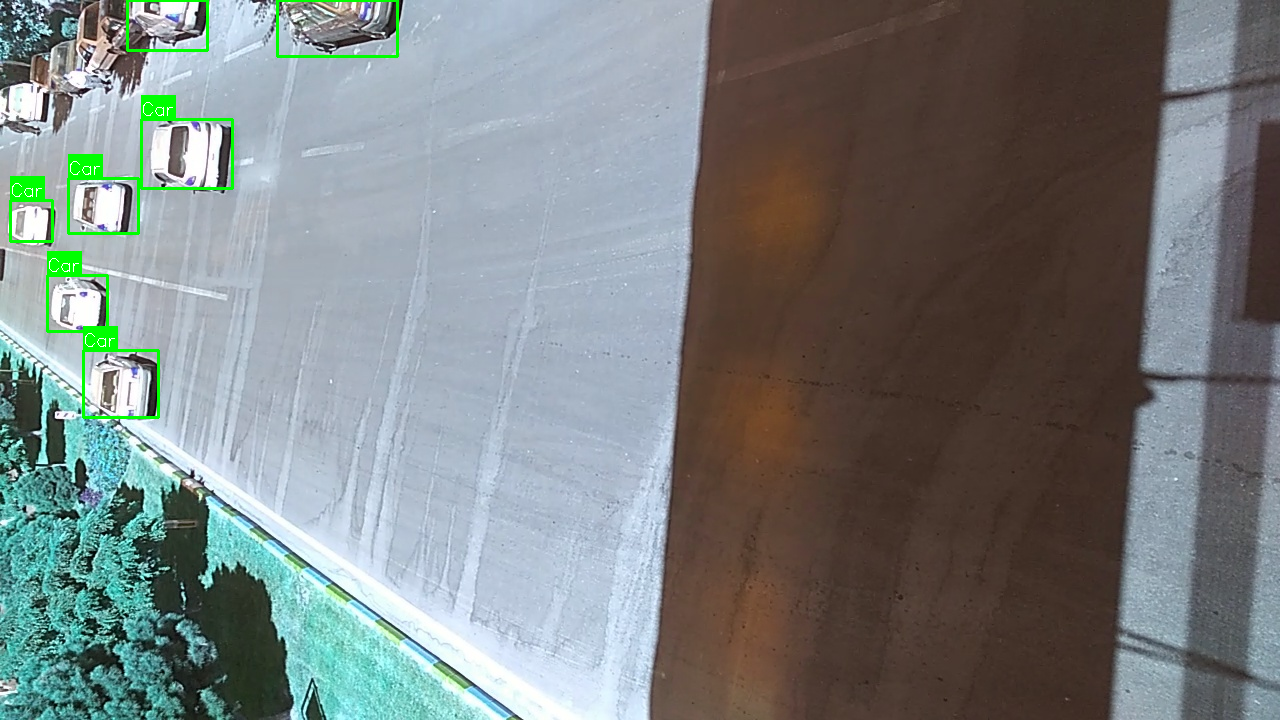

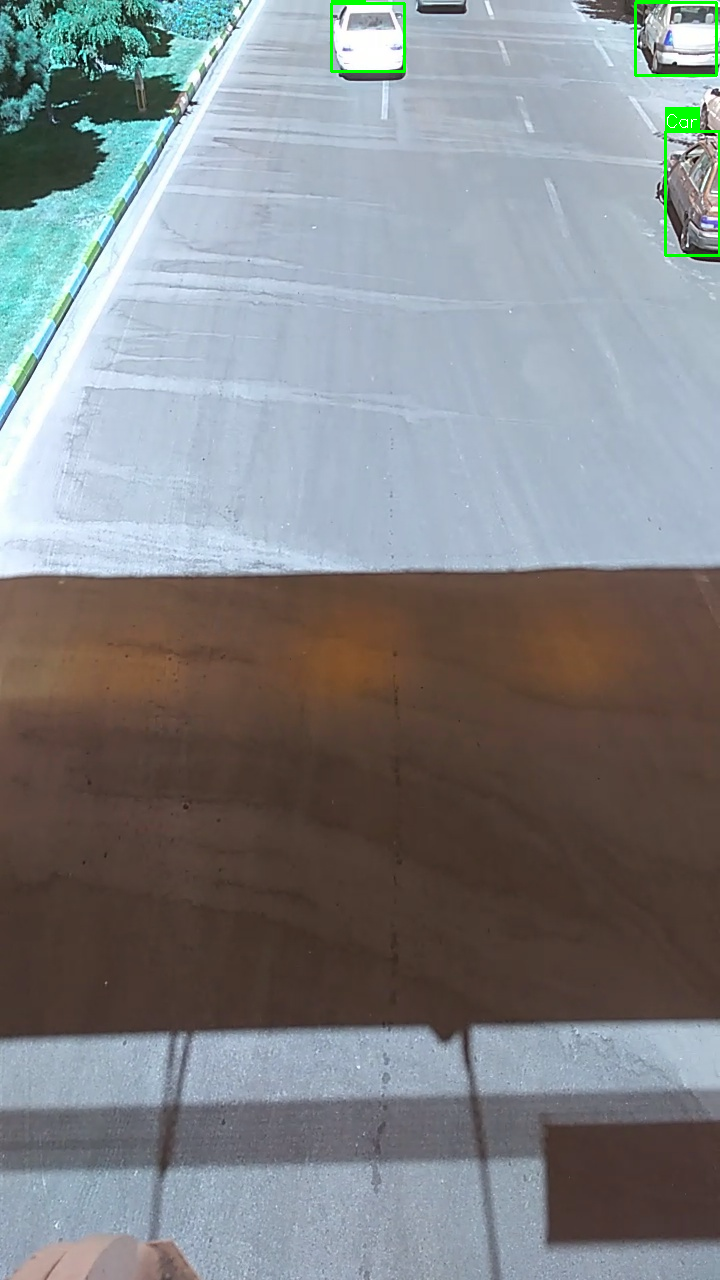


🖼️ Validation samples:


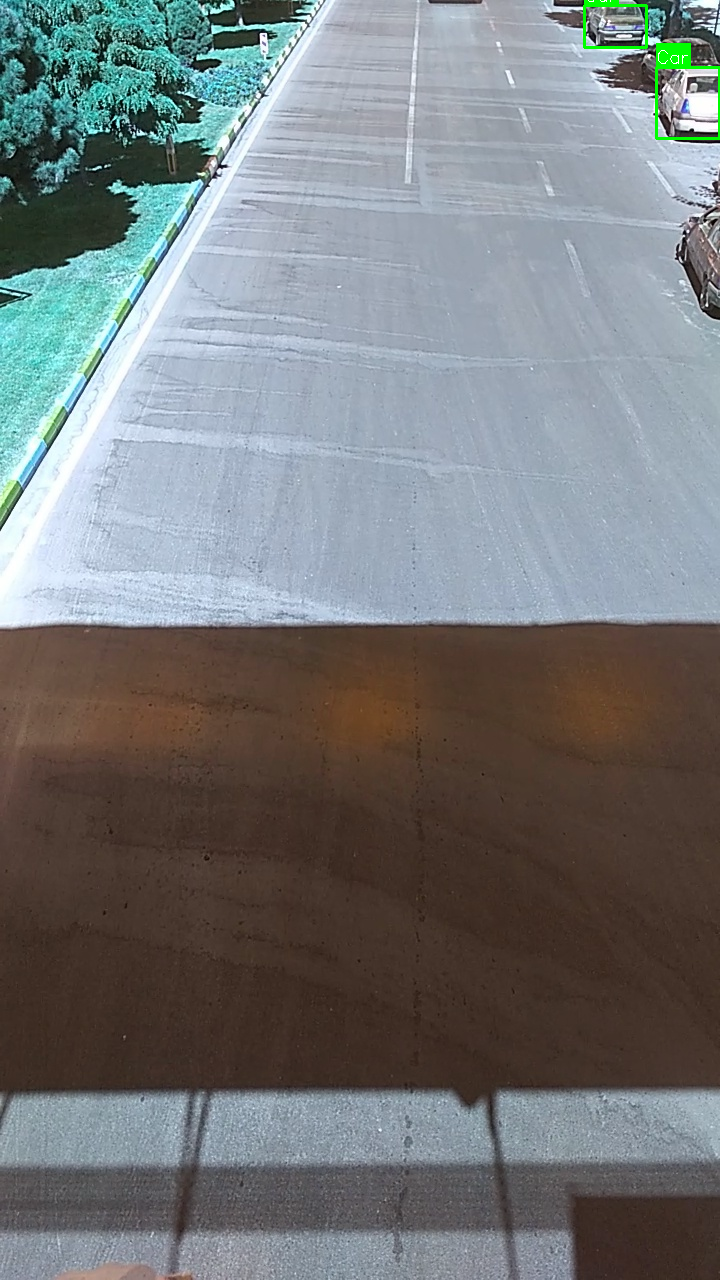

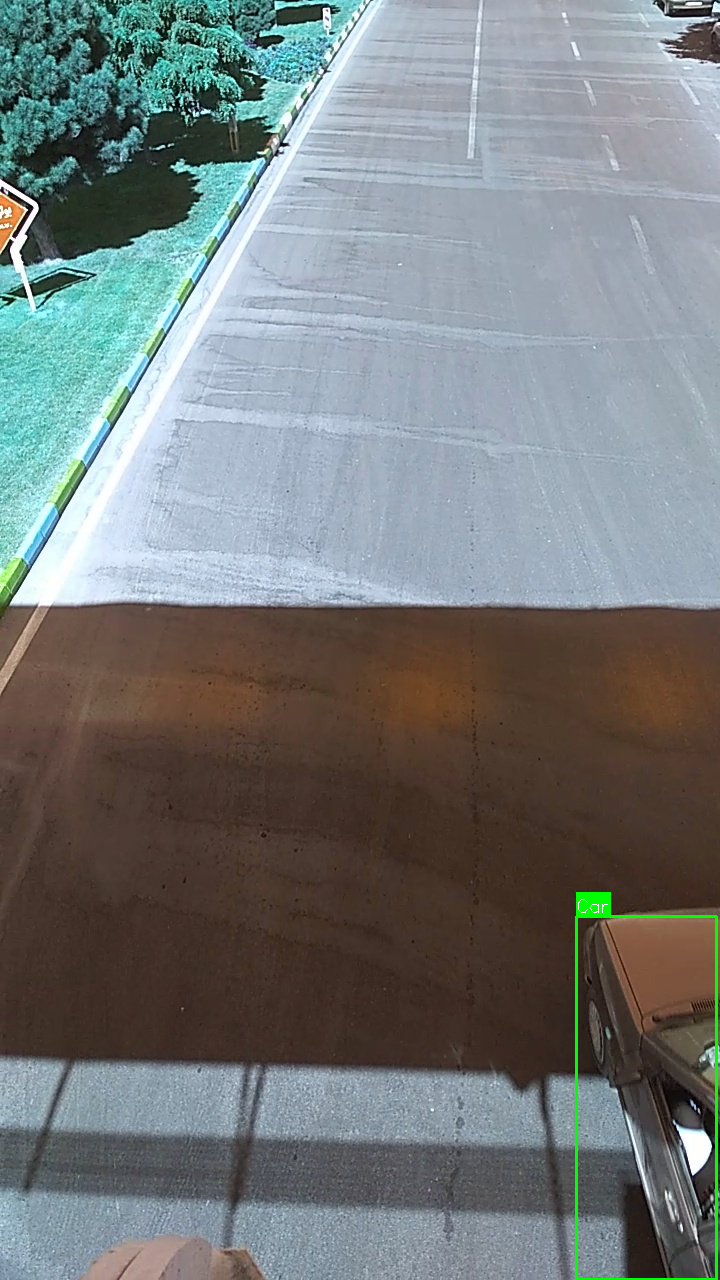

📚 Training images with labels: 1142
📊 Validation images with labels: 117
📄 Config saved: /content/dataset/dataset-vehicles/data.yaml
✅ Success! Training batches: 143


In [4]:
import os
import zipfile
from pathlib import Path
import yaml
import gdown
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

try:
    from google.colab.patches import cv2_imshow
except ImportError:
    cv2_imshow = None

from sklearn.model_selection import train_test_split


def load_class_names(class_file):
    p = Path(class_file)
    if not p.exists():
        return ["class0"]
    with open(p, "r") as f:
        names = [l.strip() for l in f.readlines() if l.strip()]
    return names if names else ["class0"]


def safe_cv2_imshow(img_rgb):
    if cv2_imshow:
        cv2_imshow(img_rgb)
    else:
        cv2.imshow("img", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        cv2.waitKey(1)


class DatasetDownloader:
    def __init__(self, file_id, output_name="dataset"):
        self.file_id = file_id
        self.output_name = output_name
        self.zip_path = Path(f"/content/{output_name}.zip")
        self.extract_path = Path(f"/content/{output_name}")

    def download_and_extract(self):
        if self.extract_path.exists():
            return self.extract_path
        url = f"https://drive.google.com/uc?id={self.file_id}"
        gdown.download(url, str(self.zip_path), quiet=False)
        with zipfile.ZipFile(self.zip_path, "r") as z:
            z.extractall(self.extract_path)
        return self.extract_path


class DataFinder:
    IMAGE_GLOBS = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG", "*.JPEG"]

    def __init__(self, root):
        self.root = Path(root)

    def find_images_by_split(self, split="train"):
        d = self.root / "images" / split
        if not d.exists():
            return []
        images = []
        for g in self.IMAGE_GLOBS:
            images.extend(sorted(d.glob(g)))
        return images

    def find_label(self, image_path):
        parts = list(image_path.parts)
        if "images" not in parts:
            return None
        idx = parts.index("images")
        split = parts[idx + 1] if idx + 1 < len(parts) else "train"
        label_path = self.root / "labels" / split / (image_path.stem + ".txt")
        return label_path if label_path.exists() else None


class BoundingBoxVisualizer:
    COLORS = [(0,255,0),(255,0,0),(0,0,255),(255,255,0),
              (255,0,255),(0,255,255),(128,0,128),(255,165,0)]

    def __init__(self, class_names):
        self.class_names = class_names

    def draw_boxes(self, image_path, finder):
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        h, w = img.shape[:2]
        label_path = finder.find_label(image_path)
        if not label_path:
            return img

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cid = int(float(parts[0]))
                xc, yc, bw, bh = map(float, parts[1:5])
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w-1, x2), min(h-1, y2)
                color = self.COLORS[cid % len(self.COLORS)]
                cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
                name = self.class_names[cid] if cid < len(self.class_names) else f"cls{cid}"
                (tw, th), baseline = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(img, (x1, y1-th-baseline-4), (x1+tw, y1), color, -1)
                cv2.putText(img, name, (x1, y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
        return img


class ImageDisplayer:
    def __init__(self, finder, class_names):
        self.finder = finder
        self.visualizer = BoundingBoxVisualizer(class_names)

    def show_samples(self, images, n=3):
        shown = 0
        for p in images:
            if shown >= n:
                break
            img = self.visualizer.draw_boxes(p, self.finder)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                safe_cv2_imshow(img_rgb)
                shown += 1


class DatasetAnalyzer:
    def __init__(self, finder, class_names):
        self.finder = finder
        self.class_names = class_names

    def analyze(self):
        summary = {
            "total_images": 0,
            "images_with_labels": 0,
            "total_objects": 0,
            "class_counts": {},
            "split_counts": {},
            "missing_labels": []
        }
        for split in ("train","val","test"):
            imgs = self.finder.find_images_by_split(split)
            summary["split_counts"][split] = len(imgs)
            summary["total_images"] += len(imgs)
            for p in imgs:
                lbl = self.finder.find_label(p)
                if not lbl:
                    summary["missing_labels"].append(p)
                    continue
                summary["images_with_labels"] += 1
                with open(lbl, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) < 1:
                            continue
                        cid = int(float(parts[0]))
                        summary["class_counts"][cid] = summary["class_counts"].get(cid, 0) + 1
                        summary["total_objects"] += 1
        return summary


class YOLODataset(Dataset):
    def __init__(self, image_files, finder, img_size=640, augment=False, class_names=None):
        self.files = list(image_files)
        self.finder = finder
        self.img_size = int(img_size)
        self.augment = augment
        self.class_names = class_names or ["class0"]

        if self.augment:
            self.transform = A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(mean=(0,0,0), std=(1,1,1)),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))
        else:
            self.transform = A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.Normalize(mean=(0,0,0), std=(1,1,1)),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        p = Path(self.files[idx])
        img_bgr = cv2.imread(str(p))
        if img_bgr is None:
            img = np.ones((self.img_size, self.img_size,3),dtype=np.uint8)*128
            bboxes,class_labels=[],[]
        else:
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            label_path = self.finder.find_label(p)
            bboxes,class_labels=[],[]
            if label_path and label_path.exists():
                with open(label_path,"r") as f:
                    for line in f:
                        parts=line.strip().split()
                        if len(parts)<5:
                            continue
                        cid=int(float(parts[0]))
                        xc,yc,w,h=map(float,parts[1:5])
                        if 0<=xc<=1 and 0<=yc<=1 and 0<w<=1 and 0<h<=1:
                            bboxes.append([xc,yc,w,h])
                            class_labels.append(cid)
        try:
            res=self.transform(image=img,bboxes=bboxes,class_labels=class_labels)
            image_t=res["image"]
            bboxes=res["bboxes"]
            class_labels=res["class_labels"]
        except:
            image_resized=cv2.resize(img,(self.img_size,self.img_size))
            image_t=torch.from_numpy(image_resized).permute(2,0,1).float()/255.0
            bboxes,class_labels=[],[]

        if bboxes:
            targets=torch.tensor([[int(c), float(x), float(y), float(w), float(h)]
                                  for c,(x,y,w,h) in zip(class_labels,bboxes)],dtype=torch.float32)
        else:
            targets=torch.zeros((0,5),dtype=torch.float32)
        return image_t, targets, str(p)


def yolo_collate(batch):
    imgs, targets, paths = zip(*batch)
    imgs = torch.stack(imgs,0)
    all_targets=[]
    for i,t in enumerate(targets):
        if t.numel()>0:
            batch_idx = torch.full((t.shape[0],1),i,dtype=torch.float32)
            all_targets.append(torch.cat([batch_idx,t],dim=1))
    if all_targets:
        all_targets=torch.cat(all_targets,dim=0)
    else:
        all_targets=torch.zeros((0,6),dtype=torch.float32)
    return imgs, all_targets, paths


def create_loaders(finder, class_names, img_size=640, batch_size=8, val_split_from_train=None):
    train_imgs = finder.find_images_by_split("train")
    val_imgs = finder.find_images_by_split("val")

    if not val_imgs and val_split_from_train:
        train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_split_from_train, random_state=42)

    train_imgs = [p for p in train_imgs if finder.find_label(p)]
    val_imgs = [p for p in val_imgs if finder.find_label(p)]

    if not train_imgs:
        print("❌ No training images with labels found!")
        return None, None

    print(f"📚 Training images with labels: {len(train_imgs)}")
    print(f"📊 Validation images with labels: {len(val_imgs)}")

    train_ds = YOLODataset(train_imgs, finder, img_size=img_size, augment=True, class_names=class_names)
    val_ds = YOLODataset(val_imgs, finder, img_size=img_size, augment=False, class_names=class_names) if val_imgs else None

    train_loader = DataLoader(train_ds, batch_size=min(batch_size, len(train_ds)), shuffle=True, collate_fn=yolo_collate)
    val_loader = DataLoader(val_ds, batch_size=min(batch_size, len(val_ds)), shuffle=False, collate_fn=yolo_collate) if val_ds else None

    return train_loader, val_loader


class DatasetManager:
    def __init__(self, dataset_root=None, file_id=None):
        self.dataset_root = Path(dataset_root) if dataset_root else None
        self.file_id = file_id
        self.finder = None
        self.class_names = None
        self.train_loader = None
        self.val_loader = None
        self.num_classes = None
        self.analysis = None

    def setup(self, download=False, export_yaml=True, yaml_name="data.yaml"):
        if download and self.file_id:
            downloader = DatasetDownloader(self.file_id)
            extracted = downloader.download_and_extract()
            self.dataset_root = Path(extracted)

        if not self.dataset_root:
            raise ValueError("dataset_root must be provided or file_id+download=True")

        print(f"📁 Dataset root: {self.dataset_root}")

        candidates = [
            self.dataset_root / "classes.txt",
            self.dataset_root / "dataset-vehicles" / "classes.txt",
            self.dataset_root / "dataset" / "classes.txt"
        ]

        class_file = None
        for c in candidates:
            if c.exists():
                class_file = c
                break

        if class_file is None:
            for p in self.dataset_root.rglob("classes*.txt"):
                class_file = p
                break

        self.class_names = load_class_names(str(class_file)) if class_file else ["class0"]
        print(f"🎯 Classes: {self.class_names}")

        self.finder = DataFinder(self.dataset_root)
        analyzer = DatasetAnalyzer(self.finder, self.class_names)
        self.analysis = analyzer.analyze()

        print(f"📊 Dataset analysis:")
        print(f"   Total images: {self.analysis['total_images']}")
        print(f"   Images with labels: {self.analysis['images_with_labels']}")
        print(f"   Total objects: {self.analysis['total_objects']}")

        for split, count in self.analysis["split_counts"].items():
            print(f"   {split}: {count} images")

        self.num_classes = max(self.analysis["class_counts"].keys()) + 1 if self.analysis["class_counts"] else len(self.class_names)

        displayer = ImageDisplayer(self.finder, self.class_names)
        train_imgs = self.finder.find_images_by_split("train")[:2]
        if train_imgs:
            print("\n🖼️ Training samples:")
            displayer.show_samples(train_imgs, n=2)

        val_imgs = self.finder.find_images_by_split("val")[:2]
        if val_imgs:
            print("\n🖼️ Validation samples:")
            displayer.show_samples(val_imgs, n=2)

        self.train_loader, self.val_loader = create_loaders(self.finder, self.class_names)

        if self.train_loader is None:
            print("❌ Failed to create data loaders - no training data available")
            return self

        if export_yaml:
            yaml_path = self.dataset_root / yaml_name
            data_dict = {
                "train": str(self.dataset_root / "images" / "train"),
                "val": str(self.dataset_root / "images" / "val"),
                "nc": self.num_classes,
                "names": self.class_names
            }
            with open(yaml_path, "w") as f:
                yaml.dump(data_dict, f)
            print(f"📄 Config saved: {yaml_path}")

        return self

    def prepare(self):
        return self.train_loader, self.val_loader, self.num_classes, self.class_names, self.analysis


if __name__ == "__main__":
    dataset_root = "/content/dataset/dataset-vehicles"

    if os.path.exists(dataset_root):
        print("📁 Using existing dataset")
        manager = DatasetManager(dataset_root=dataset_root)
    else:
        print("📥 Downloading dataset")
        file_id = "1ErCoR4PZUKpFyiRtQ5YJVg4gTKPdjj2F"
        manager = DatasetManager(file_id=file_id)

    manager.setup(download=not os.path.exists(dataset_root))
    train_loader, val_loader, nc, names, analysis = manager.prepare()

    if train_loader:
        print(f"✅ Success! Training batches: {len(train_loader)}")
    else:
        print("❌ No training data available")

In [7]:

import copy
import csv
import os
import warnings
import sys
from pathlib import Path

import numpy as np
import torch
import tqdm
import yaml
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torch.nn as nn

warnings.filterwarnings("ignore")

In [ ]:
CLASS_NAMES = ['Car', 'Motorcycle', 'Truck', 'Bus', 'Bicycle']
NUM_CLASSES = len(CLASS_NAMES)

class YoloTrainer:
    def __init__(self, args, params):
        self.args = args
        self.params = params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device:", self.device)

        num_classes = NUM_CLASSES
        multi_head = params.get('multi_head', False)
        self.model = YOLOv8Hybrid(num_classes=num_classes, multi_head=multi_head).to(self.device)

        self.world_size = 1
        self.accumulate = max(round(64 / max(1, args['batch_size'])), 1)
        self.params['weight_decay'] = float(self.params.get('weight_decay', 0.0005))

        # FIX: Check model output dimensions before proceeding
        with torch.no_grad():
            t = torch.randn(1,3,args['input_size'],args['input_size']).to(self.device)
            o = self.model(t)
            print("Model output shape:", o.shape)
            expected_channels = 4 + 1 + num_classes  # bbox(4) + obj(1) + classes
            print(f"Expected channels: {expected_channels} (bbox:4 + obj:1 + classes:{num_classes})")
            print(f"Actual channels: {o.shape[1]}")

            # Verify the model has the correct number of output channels
            if o.shape[1] != expected_channels:
                print(f"❌ ERROR: Model output channels ({o.shape[1]}) don't match expected ({expected_channels})")
                print(f"   Expected: 4 (bbox) + 1 (obj) + {num_classes} (classes) = {expected_channels}")
                print(f"   Actual: {o.shape[1]}")
                # Fix the model output channels
                self._fix_model_output_channels(num_classes)

        self.optimizer = self._setup_optimizer()
        for g in self.optimizer.param_groups:
            g.setdefault('initial_lr', g.get('lr', self.params.get('lr0', 0.001)))

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=self._get_lr_lambda())
        self.ema = EMA(self.model)

        loss_params = {'cls':params.get('cls_loss',0.5),'box':params.get('box_loss',5.0),'obj':params.get('obj_loss',1.0)}
        self.criterion = ComputeLoss(self.model, loss_params)

        self.best_loss = float('inf')
        os.makedirs('weights', exist_ok=True)

    def _fix_model_output_channels(self, num_classes):
        """Fix the model output channels to match the number of classes"""
        print("🛠️ Attempting to fix model output channels...")

        expected_channels = 4 + 1 + num_classes

        if self.model.multi_head:
            # Fix multi-head outputs
            print("Fixing multi-head outputs...")
            self.model.head_p3 = GhostHead(32, num_classes)
            self.model.head_p4 = GhostHead(48, num_classes)
            self.model.head_p5 = GhostHead(64, num_classes)
        else:
            # Fix single head output
            print("Fixing single head output...")
            self.model.head = GhostHead(32, num_classes)

        # Update model parameters
        self.model.num_classes = num_classes
        self.model.nc = num_classes
        self.model.no = expected_channels

        # Verify the fix
        with torch.no_grad():
            t = torch.randn(1,3,self.args['input_size'],self.args['input_size']).to(self.device)
            o = self.model(t)
            print("Fixed model output shape:", o.shape)
            if o.shape[1] == expected_channels:
                print("✅ Model output channels fixed successfully!")
            else:
                print("❌ Failed to fix model output channels")
                raise ValueError(f"Model output channels ({o.shape[1]}) don't match expected ({expected_channels})")

    def _get_lr_lambda(self):
        def lr_lambda(epoch):
            return (1 - epoch / float(self.args['epochs'])) * (1.0 - float(self.params.get('lrf', 0.001))) + float(self.params.get('lrf', 0.001))
        return lr_lambda

    def _setup_optimizer(self):
        lr0 = float(self.params.get('lr0', 0.001))
        weight_decay = float(self.params.get('weight_decay', 0.0001))
        return torch.optim.AdamW(self.model.parameters(), lr=lr0, weight_decay=weight_decay, betas=(0.9,0.999))

    def _load_dataset(self):
        dataset_path = self.params.get('data',{}).get('path','./synthetic_vehicles')
        print("Loading dataset from:", dataset_path)

        # FIX: Create DataFinder and use CLASS_NAMES
        finder = DataFinder(dataset_path)

        train_loader, val_loader = create_loaders(
            finder=finder,
            class_names=CLASS_NAMES,
            img_size=self.args['input_size'],
            batch_size=self.args['batch_size'],
            val_split_from_train=0.1
        )

        if train_loader:
            for images, targets, _ in train_loader:
                print("Sanity check - images:", images.shape, "targets:", targets.shape)
                # Check target format
                if targets.numel() > 0:
                    print("Target sample - first row:", targets[0])
                    print("Target range - class indices:", torch.unique(targets[:, 1].int()))
                break
        else:
            print("ERROR: No training data loaded!")

        return train_loader, val_loader

    def train_epoch(self, loader, epoch, warmup_iters, num_batches):
        if loader is None:
            return 1.0, 0

        self.model.train()
        running_loss = 0.0
        batches_with_targets = 0
        empty_batches = 0

        self.optimizer.zero_grad()
        pbar = tqdm.tqdm(enumerate(loader), total=num_batches, desc=f"Epoch {epoch+1}/{self.args['epochs']}")

        for i, (images, targets, _) in pbar:
            iteration = i + epoch * num_batches
            images = images.to(self.device).float()
            targets = targets.to(self.device)

            if targets.numel() == 0:
                empty_batches += 1
                if empty_batches <= 3:
                    print(f"WARNING: Batch {i} has no targets, skipping")
                continue
            else:
                batches_with_targets += 1

            # Debug: Check target class distribution
            if i == 0 and epoch == 0:
                unique_classes = torch.unique(targets[:, 1].int())
                print(f"📊 Classes in first batch: {unique_classes.tolist()}")

            # warmup
            if iteration < warmup_iters:
                lr_scale = np.interp(iteration, [0, warmup_iters], [0.2, 1.0])
                for g in self.optimizer.param_groups:
                    g['lr'] = g['initial_lr'] * lr_scale

            # forward
            outputs = self.model(images)

            # Debug: Check output dimensions
            if i == 0 and epoch == 0:
                print(f"🔍 Output shape: {outputs.shape}")
                print(f"🔍 Target shape: {targets.shape}")

            loss = self.criterion(outputs, targets)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: invalid loss at iter {i}, skipping")
                self.optimizer.zero_grad()
                continue

            loss.backward()

            if (i + 1) % self.accumulate == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.ema.update(self.model)

            running_loss += float(loss.item())
            avg_loss = running_loss / (batches_with_targets if batches_with_targets>0 else 1)
            pbar.set_postfix({'loss': f"{avg_loss:.4f}", 'targets': batches_with_targets, 'empty': empty_batches})

        print(f"Epoch {epoch+1}: {batches_with_targets} batches with targets, {empty_batches} empty batches")
        if batches_with_targets == 0:
            return 1.0, 0
        avg_loss = running_loss / batches_with_targets
        return avg_loss, batches_with_targets

    @torch.no_grad()
    def validate(self, loader):
        if loader is None:
            return float('inf'), 0.0, 0.0

        self.ema.ema.eval()
        val_loss = 0.0
        batches = 0
        for images, targets, _ in loader:
            images = images.to(self.device).float()
            targets = targets.to(self.device)
            if targets.numel() == 0:
                continue
            outputs = self.ema.ema(images)
            loss = self.criterion(outputs, targets)
            if not torch.isnan(loss) and not torch.isinf(loss):
                val_loss += float(loss.item())
                batches += 1
        avg = val_loss / batches if batches>0 else float('inf')
        return avg, 0.0, 0.0

    def train(self):
        train_loader, val_loader = self._load_dataset()

        # FIX: Check if train_loader is valid before proceeding
        if train_loader is None:
            print("❌ ERROR: Failed to load training data. Cannot start training.")
            return

        num_batches = len(train_loader)
        warmup_iters = max(round(self.params.get('warmup_epochs', 3) * num_batches), 100)
        csv_file = open('weights/training_log.csv', 'w', newline='')
        writer = csv.DictWriter(csv_file, fieldnames=['epoch','train_loss','val_loss','mAP50','mAP','batches_with_targets'])
        writer.writeheader()

        print(f"✅ Training samples: {len(train_loader.dataset)}")
        print(f"✅ Validation samples: {len(val_loader.dataset) if val_loader else 0}")

        for epoch in range(self.args['epochs']):
            try:
                train_loss, batches_with_targets = self.train_epoch(train_loader, epoch, warmup_iters, num_batches)
                self.scheduler.step()
                val_loss, map50, map_val = self.validate(val_loader) if val_loader else (float('inf'),0.0,0.0)

                writer.writerow({'epoch': epoch+1, 'train_loss': train_loss, 'val_loss': val_loss,
                                 'mAP50': map50, 'mAP': map_val, 'batches_with_targets': batches_with_targets})
                csv_file.flush()

                print(f"Epoch {epoch+1}/{self.args['epochs']} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

                if train_loss < self.best_loss:
                    self.best_loss = train_loss
                    torch.save({'epoch': epoch, 'model_state_dict': self.ema.ema.state_dict(),
                                'optimizer_state_dict': self.optimizer.state_dict(), 'best_loss': self.best_loss,
                                'params': self.params}, "weights/best_model.pth")
                    print(f"💾 Saved best model: {self.best_loss:.4f}")

                torch.save({'epoch': epoch, 'model_state_dict': self.ema.ema.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(), 'best_loss': self.best_loss,
                            'params': self.params}, "weights/latest_model.pth")

            except Exception as e:
                import traceback
                traceback.print_exc()
                print(f"❌ Error in epoch {epoch}: {e}")
                break  # Stop training on error

        csv_file.close()
        print("🎯 Training completed. Best loss:", self.best_loss)

# -------------------------------
# Run
# -------------------------------
if __name__ == "__main__":
    # Config
    args = {'input_size': 640, 'batch_size': 8, 'epochs': 10}
    safe_config = {
        'nc': NUM_CLASSES,
        'multi_head': False,
        'lr0': 0.001,
        'lrf': 0.01,
        'momentum': 0.9,
        'weight_decay': 0.0001,
        'warmup_epochs': 3,
        'cls_loss': 0.5,
        'box_loss': 5.0,
        'obj_loss': 1.0,
        'data': {'path': '/content/dataset/dataset-vehicles'},
        'grid_size': 20
    }

    print("="*40)
    print("STARTING TRAINING")
    print(f"Classes: {CLASS_NAMES}")
    print(f"Number of classes: {NUM_CLASSES}")
    print("="*40)

    trainer = YoloTrainer(args, safe_config)
    trainer.train()

STARTING TRAINING
Classes: ['Car', 'Motorcycle', 'Truck', 'Bus', 'Bicycle']
Number of classes: 5
Device: cpu
Model output shape: torch.Size([1, 10, 320, 320])
Expected channels: 10 (bbox:4 + obj:1 + classes:5)
Actual channels: 10
Loading dataset from: /content/dataset/dataset-vehicles
📚 Training images with labels: 1142
📊 Validation images with labels: 117
Sanity check - images: torch.Size([8, 3, 640, 640]) targets: torch.Size([15, 6])
Target sample - first row: tensor([0.0000, 0.0000, 0.4933, 0.3081, 0.2427, 0.3555])
Target range - class indices: tensor([0, 1, 2, 3], dtype=torch.int32)
✅ Training samples: 1142
✅ Validation samples: 117


Epoch 1/10:   0%|          | 0/143 [00:00<?, ?it/s]

📊 Classes in first batch: [0, 4]
🔍 Output shape: torch.Size([8, 10, 320, 320])
🔍 Target shape: torch.Size([26, 6])
